# Twitter Sentiment Analysis Pipeline

## Import dependencies

In [1]:
# System
import re
import multiprocessing

# Data manipulation
import pandas as pd
import numpy as np

# Graphing
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
from jupyterthemes import jtplot
jtplot.style(theme='onedork')

In [2]:
# ML

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, get_scorer, f1_score,roc_auc_score,precision_score
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB

from joblib import dump, load

In [3]:
# NLP
from wordcloud import WordCloud

from xgboost import XGBClassifier

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Prep nltk library
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

/Users/petergish/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/petergish/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/petergish/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/petergish/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
def extract(path, col_rename_map, target_words):

    # Import data
    raw_tweets_df = pd.read_csv(path)
    
    # Rename columns
    tweets_df = raw_tweets_df[list(col_rename_map.keys())].rename(columns=col_rename_map)

    # Drop duplicate tweets
    tweets_df = tweets_df.drop_duplicates(subset='tweet', keep='first')

    # Initialize Lemmatizer and stopwords
    lemma = WordNetLemmatizer()
    stop_words = stopwords.words("english")

    def cleanTweet(tweet):

        tweet = tweet.lower()
        tweet = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', tweet)
        tweet = re.sub('\$[a-zA-Z0-9]*', ' ', tweet)
        tweet = re.sub('\@[a-zA-Z0-9]*', ' ', tweet)
        tweet = re.sub('[^a-zA-Z\']', ' ', tweet)
        tweet = ' '.join( [w for w in tweet.split() if len(w)>1] )
        
        lem_stopwords = [lemma.lemmatize(x) for x in nltk.wordpunct_tokenize(tweet) 
                        if x not in stop_words]
        tweet = ' '.join(lem_stopwords)
        
        return [lemma.lemmatize(x, nltk.corpus.reader.wordnet.VERB) for x in nltk.wordpunct_tokenize(tweet) 
                if x not in stop_words]


    def cleanHashtags(hashtags):

        if hashtags:
            hashtags = hashtags.lower()
            hashtags = re.sub('\$[a-zA-Z0-9]*', ' ', hashtags)
            hashtags = re.sub('[^a-zA-Z]', ' ', hashtags)
            hashtags=hashtags.strip() 
        return hashtags
    
    
    # Clean tweets
    tweets_df['clean_tweet'] = tweets_df['tweet'].apply(lambda x: cleanTweet(x))
    tweets_df['cleaned_tweet'] = tweets_df['clean_tweet'].apply(lambda x:' '.join(x))


    # Clean hashtags
    tweets_df["hashtags"] = tweets_df["hashtags"].astype(str)
    tweets_df["hashtags"] = tweets_df["hashtags"].apply(lambda x: cleanHashtags(x))

    # Convert date to datetime and extract month/year
    tweets_df['date'] = pd.to_datetime(tweets_df['date'])
    tweets_df['month'] = tweets_df['date'].dt.month
    tweets_df['year'] = tweets_df['date'].dt.year


    # Remove all tweets which do not have the words "ukraine" or "russia"
    target_tweets_df = tweets_df.copy()
    target_tweets_df = target_tweets_df[target_tweets_df["cleaned_tweet"].str.contains('|'.join(target_words))]

    return target_tweets_df, tweets_df

In [5]:
def transform(filtered_df, cumulative_df, load_word2vec='', save_word2vec='', 
                load_embeddings='', save_embeddings=''):
    
    # Preseve original df
    transform_tweets_df = filtered_df.copy()
    
    if load_word2vec:
        word_vectors = Word2Vec.load(load_word2vec).wv

    else:
        # Converting the "clean_text" column in the format supported by embeddings.
        row_sentences = [row for row in cumulative_df["clean_tweet"]]

        # Automatically detect common phrases (bigrams) from a list of sentences.
        phrases = Phrases(row_sentences, min_count=1, progress_per=50000)
        bigram = Phraser(phrases)
        sentences = bigram[row_sentences]
        
        # Initialize vector model
        w2v_model = Word2Vec(min_count=4,
                            window=5,
                            vector_size =300,
                            sample=1e-5, 
                            alpha=0.03, 
                            min_alpha=0.0007, 
                            negative=20,
                            seed= 42,
                            workers=multiprocessing.cpu_count()-1)


        # Build vocab of the word2vec model from the custom data
        w2v_model.build_vocab(sentences, progress_per=50000)

        # Train the model
        w2v_model.train(sentences, 
                    total_examples=w2v_model.corpus_count, 
                    epochs=30, 
                    report_delay=1)
        
        if save_word2vec:
            w2v_model.save(save_word2vec)

        word_vectors = w2v_model.wv
    
    # Build KMeans model to cluster words into positive, negative, and neutral clusters
    cluster_model = KMeans(n_clusters=3, 
               max_iter=1000, 
               random_state=42, 
               n_init=50).fit(X=word_vectors.vectors.astype('double'))
                        

    # Mapping for sentiment encodings
    emotion = { 0: "neutral", 1: "positive", -1: "negative" }

    if load_embeddings:
        words = pd.read_csv(load_embeddings)

    else:
        # Create a DataFrame of words with their embeddings and cluster values
        words = pd.DataFrame(word_vectors.index_to_key)
        words.columns = ['words']
        words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
        words['cluster'] = words.vectors.apply(lambda x: cluster_model.predict([np.array(x)]))
        words.cluster = words.cluster.apply(lambda x: x[0])

        # Assign 1 to positive values, 0 to neutral and -1 for negative values
        words['cluster_value'] = [1 if i==2 else 0 if i==0 else -1 for i in words.cluster]
        words['closeness_score'] = words.apply(lambda x: 1/(cluster_model.transform([x.vectors]).min()), axis=1)


        # Map sentiment encodings
        words["sentiments"] = words["cluster_value"].map(emotion)

        if save_embeddings:
            words.to_csv(save_embeddings)

    # Define a function to get the sentiment for the entire tweet
    def getSentiments(row, sentiment_dict):
        total=0
        count=0
        test = row["clean_tweet"]
        for t in test:
            if words_cluster_dict.get(t):
                total += int(sentiment_dict.get(t))
            count += 1 
            
        avg = total / count
        return -1 if (avg < -0.15) else 1 if (avg > 0.15) else 0


    # Create a dictionary of the word and its cluster value
    words_cluster_dict = dict(zip(words.words, words.cluster_value))


    # Add sentiment column
    transform_tweets_df["sentiment"] = transform_tweets_df.apply(getSentiments,
                                                         args=(words_cluster_dict,),
                                                         axis=1)
    
    transform_tweets_df["sentiments_val"] = transform_tweets_df["sentiment"].map(emotion)


    return transform_tweets_df, words

In [6]:
def model(sent_analyzed_df, load_svc='', save_svc='', load_nb='', save_nb='', load_vectorizer='', save_vectorizer=''):
    # Convert each sentiment to df (no need to worry about memory crash, small dataset)
    pos_df = sent_analyzed_df[sent_analyzed_df["sentiments_val"]=="positive"]
    neg_df = sent_analyzed_df[sent_analyzed_df["sentiments_val"]=="negative"]
    neu_df = sent_analyzed_df[sent_analyzed_df["sentiments_val"]=="neutral"]

    # Combine all sentiments in one df
    sentiments_df_list = [pos_df, neg_df, neu_df] 
    agg_sentiment_df = pd.concat(sentiments_df_list)

    # Split the data to training, testing, and validation data 
    train_test_df, valid_df = train_test_split(agg_sentiment_df, test_size=0.2, random_state=10)

    X = train_test_df['cleaned_tweet']
    y = train_test_df['sentiment']

    # Split the dataset set int0 training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Instantiate TfidfVectorizer 
    if load_vectorizer:
        vectorizer = load(load_vectorizer)
    else:
        vectorizer = TfidfVectorizer(min_df=3,
                                    sublinear_tf=True,
                                    ngram_range=(1,2),
                                    stop_words='english')

    # Fit vectorizer
    X_train_tf = vectorizer.fit_transform(X_train.reset_index()["cleaned_tweet"]).toarray()
    X_test_tf = vectorizer.transform(X_test.reset_index()["cleaned_tweet"]).toarray()

    feature_names = vectorizer.get_feature_names_out()

    # Create a dict of Sentiment_val: sentiments to use with the confusion matrix
    sentiment_id_df = agg_sentiment_df[['sentiments_val', 'sentiment']].drop_duplicates().sort_values('sentiment')
    sentiment_to_id = dict(sentiment_id_df.values)

    ## LinearSVC ##

    if load_svc:
        linearSVC = load(load_svc)

    else:
        # Instantiate the model
        linearSVC = LinearSVC(random_state=0)

        # Fit the model
        linearSVC.fit(X_train_tf, y_train)

        if save_svc:
            dump(linearSVC, save_svc)

    # Predict
    svc_y_pred = linearSVC.predict(X_test_tf)

    # Build confusion matrix to evaluate the model results
    svc_conf_mat = confusion_matrix(y_test, svc_y_pred)

    # Get classification report
    svc_classification = metrics.classification_report(y_test, svc_y_pred)

    # Use score method to get accuracy of model
    svc_score = linearSVC.score(X_test_tf, y_test)

    ## MultinomialNB ##

    if load_nb:
        multiNB = load(load_nb)

    else:
        # Instantiate the model
        multiNB = MultinomialNB()

        # Fit the model
        multiNB.fit(X_train_tf, y_train)

        if save_nb:
            dump(multiNB, save_nb)

    # Predict
    nb_y_pred = multiNB.predict(X_test_tf)

    # Build confusion matrix to evaluate the model results
    nb_conf_mat = confusion_matrix(y_test, nb_y_pred)

    # Get classification report
    nb_classification = metrics.classification_report(y_test, nb_y_pred)

    # Use score method to get accuracy of model
    nb_score = multiNB.score(X_test_tf, y_test)

    if save_vectorizer:
        dump(vectorizer, save_vectorizer)
    elif save_svc or save_nb:
        vector_out_match = re.search(r'\/[^/]*$', save_svc if save_svc else save_nb)
        if not vector_out_match.group():
            print('Error: could not extract default vectorizer output path')
        else:
            dump(vectorizer, re.sub(vector_out_match.group(), '/vectorizer.joblib', vector_out_match.string))

    return {
        'LinearSVC': {
            'model': linearSVC,
            'conf_mat': svc_conf_mat,
            'classification': svc_classification,
            'score': svc_score,
        },
        'MultinomialNB': {
            'model': multiNB,
            'conf_mat': nb_conf_mat,
            'classification': nb_classification,
            'score': nb_score,
        },
        'features': feature_names,
        'vectorizer': vectorizer,
        'sentiment_id': sentiment_id_df,
        'sentiment_to': sentiment_to_id
    }

In [7]:
def pipeline(path, column_mappings, target_words, build_models=False, io_options={}):

    target_df, all_tweets_df = extract(path=path, 
                                col_rename_map=column_mappings,
                                target_words=target_words)

    

    transform_tweets_df, word_vecs = transform(filtered_df=target_df, 
                                                cumulative_df=all_tweets_df,
                                                load_word2vec=io_options.get('load_word2vec', ''),
                                                save_word2vec=io_options.get('save_word2vec', ''),
                                                load_embeddings=io_options.get('load_embedding', ''),
                                                save_embeddings=io_options.get('save_embeddings', ''))

    model_dict = None
    if build_models:
        model_dict = model(sent_analyzed_df=transform_tweets_df,
                            load_svc=io_options.get('load_svc', ''),
                            save_svc=io_options.get('save_svc', ''),
                            load_nb=io_options.get('load_nb', ''),
                            save_nb=io_options.get('save_nb', ''),
                            load_vectorizer=io_options.get('load_vectorizer', ''),
                            save_vectorizer=io_options.get('save_vectorizer', ''))


    return transform_tweets_df, word_vecs, model_dict

In [8]:
data_path = '../data/raw/slava_ukraini_tweets.csv'
col_rename_map = {
    'date': 'date',
    'user_name': 'username',
    # 'user_description': 'description',
    # 'user_location': 'location',
    'retweets': 'retweets',
    'text': 'tweet',
    'hashtags': 'hashtags'
}
keywords = ['ukraine', 'russia', 'zelensky']
io_params = {
    'load_word2vec': '',
    'save_word2vec': '../models/word2vec.model',
    'load_embeddings': '',
    'save_embeddings': '../data/embeddings/words.csv',
    'load_svc': '',
    'save_svc': '../models/linearSVC.joblib',
    'load_nb': '',
    'save_nb': '../models/multinomialNB.joblib',
    'load_vectorizer': '',
    'save_vectorizer': '../models/vectorizer.joblib'
}

sentiment_df, word_vecs, model_dict = pipeline(path=data_path,
                                                column_mappings=col_rename_map,
                                                target_words=keywords,
                                                io_options=io_params,
                                                build_models=True)

/Users/petergish/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/petergish/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/petergish/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

In [21]:
class GraphicProcessors:
    
    def generateWordcloud(text):
        words=' '.join([words for words in text])
        wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(words)
        plt.figure(figsize=(10, 7))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis('off')
        plt.show()


    graphWordDistribution = lambda word_vecs: GraphicProcessors.graphDistribution(word_vecs, 'sentiments', 'Sentiment Distribution of Words')
    graphTweetDistribution = lambda tweet_df: GraphicProcessors.graphDistribution(tweet_df, 'sentiments_val', 'Sentiment Distribution of Tweets')

    def graphDistribution(df, plot_col, title=''):
        # Plot pie chart of Sentiment Distribution of words
        fig = plt.gcf()
        fig.set_size_inches(7,7)
        colors = ["cyan","pink","yellow"]

        pie_df = df[plot_col].value_counts().reset_index()

        plt.pie(pie_df[plot_col],
                labels=pie_df["index"],
                radius=2,
                colors=colors,
                autopct="%1.1f%%")

        plt.axis('equal')
        if title:
            plt.title(title, fontsize=20)
        plt.show()
        return pie_df


    def graphKeywordSentiment(df, keywords):
        # Inspect keyword sentiment
        pattern = '|'.join(keywords)
        keyword_sent_df = df[(df["cleaned_tweet"].str.contains(pattern))]
        sns.countplot(x=keyword_sent_df["sentiments_val"]);


    graphTop10Usernames = lambda tweets_df: GraphicProcessors.graphCounts(tweets_df, 'username', 'sentiments_val', 'Top 10 Highest Tweeting usernames', tweets_df['username'].value_counts().iloc[:10].index)
    graphTop10Hashtags = lambda tweets_df: GraphicProcessors.graphCounts(tweets_df, 'hashtags', 'sentiments_val', 'Top 10 Hashtags', tweets_df['hashtags'].value_counts().iloc[1:10].index, (15,10))

    def graphCounts(df, x_col, hue_col=None, title='', order=None, plt_size=(10,8)):
        fig = plt.subplots(figsize=plt_size)

        if title:
            plt.title(title, fontsize=20)

        chart = sns.countplot(x=x_col, 
                                data=df, 
                                palette="Set2", 
                                hue=hue_col,
                                order=order)

        chart.set_xticklabels(chart.get_xticklabels(),
                                rotation=30, 
                                horizontalalignment='right')
        return chart


    def graphConfusionmatrix(conf_mat, sentiment_id_df):
        fig, ax = plt.subplots(figsize=(5,5))
        sns.heatmap(conf_mat, 
                    annot=True, 
                    fmt='d',
                    xticklabels=sentiment_id_df.sentiments_val.values, 
                    yticklabels=sentiment_id_df.sentiment.values)

        plt.ylabel('Actual')
        plt.xlabel('Predicted')


    def graphCoefficients(model, feature_names, top_features=20):

        coefs_with_fns = sorted(zip(model.coef_[0], feature_names)) 
        df_feat = pd.DataFrame(coefs_with_fns)
        df_feat.columns = 'coefficient','word'
        df_feat.sort_values(by='coefficient')

        size = len(feature_names)
        coef_neg = model.coef_[-1][:size]
        coef_pos = model.coef_[1][:size]
        top_positive_coefficients = np.argsort(coef_pos[coef_pos>0])[-top_features:]
        top_negative_coefficients = np.argsort(coef_pos[coef_neg<0])[:top_features]
        top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
        coef=np.hstack([coef_neg,coef_pos])
        
        # create plot
        fig = plt.figure(figsize=(15, 5))
        colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
        plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
        feature_names = np.array(feature_names)
        plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
        title="Positive and Negative Labels"
        plt.title(title)
        plt.show()

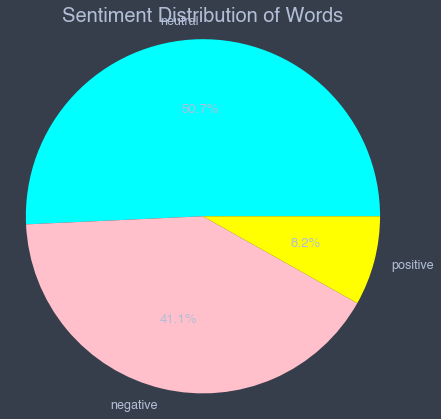

,index,sentiments
0,neutral,2368
1,negative,1919
2,positive,381


In [10]:
GraphicProcessors.graphWordDistribution(word_vecs)

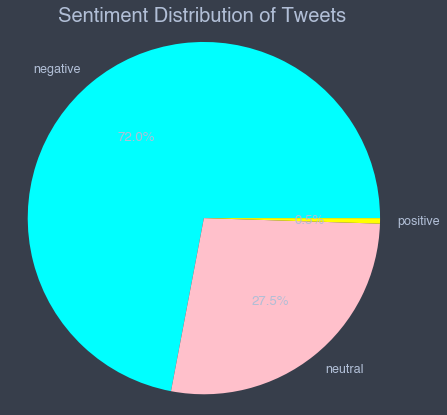

,index,sentiments_val
0,negative,7633
1,neutral,2914
2,positive,53


In [11]:
GraphicProcessors.graphTweetDistribution(sentiment_df)

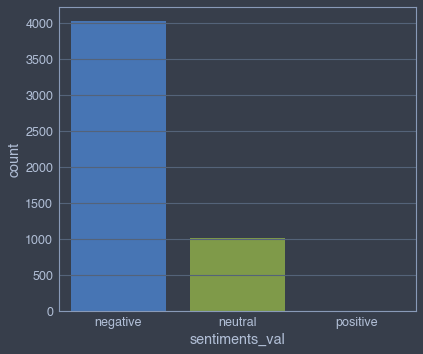

In [12]:
GraphicProcessors.graphKeywordSentiment(sentiment_df, ['russia'])

<AxesSubplot:title={'center':'Top 10 highest tweeting usernames'}, xlabel='username', ylabel='count'>

/Users/petergish/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7457 (\N{LATIN LETTER SMALL CAPITAL W}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/petergish/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7431 (\N{LATIN LETTER SMALL CAPITAL E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/petergish/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7458 (\N{LATIN LETTER SMALL CAPITAL Z}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/petergish/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127987 (\N{WAVING WHITE FLAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/petergish/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/IPython/core/pylabtools.

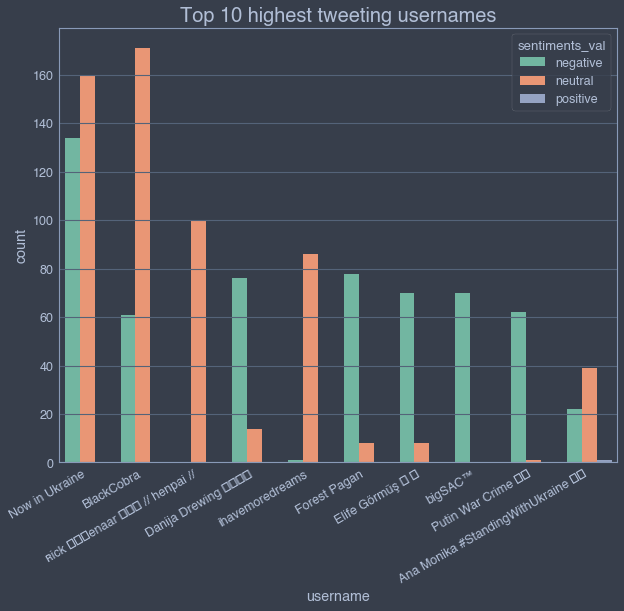

In [13]:
GraphicProcessors.graphCounts(sentiment_df, 
                                x_col='username', 
                                hue_col='sentiments_val', 
                                title='Top 10 highest tweeting usernames', 
                                order=sentiment_df['username'].value_counts().iloc[:10].index)

<AxesSubplot:title={'center':'Top 10 Hashtags'}, xlabel='hashtags', ylabel='count'>

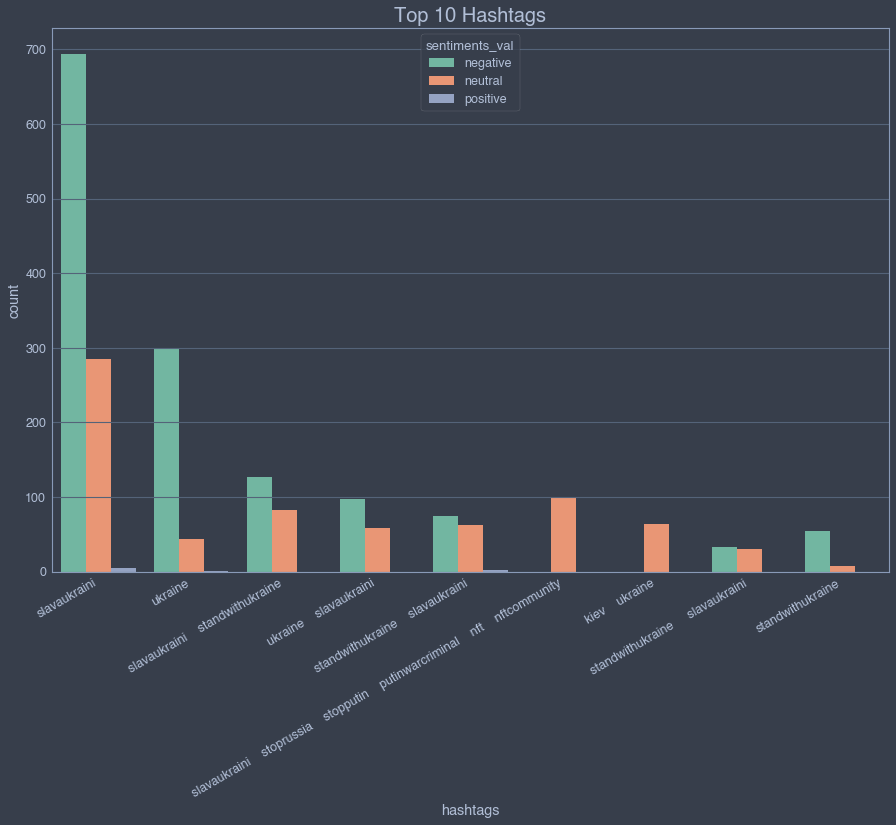

In [14]:
GraphicProcessors.graphCounts(sentiment_df, 
                                x_col='hashtags', 
                                hue_col='sentiments_val', 
                                title='Top 10 Hashtags', 
                                order=sentiment_df['hashtags'].value_counts().iloc[1:10].index, 
                                plt_size=(15,10))

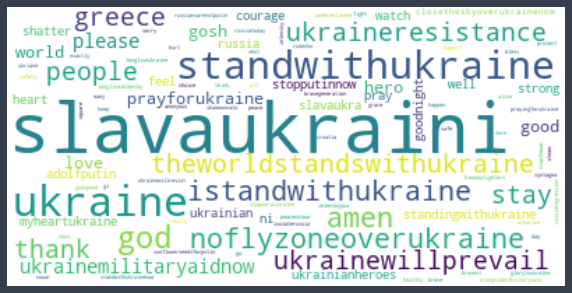

In [15]:
GraphicProcessors.generateWordcloud(sentiment_df[sentiment_df["sentiment"]==1]["cleaned_tweet"].values)

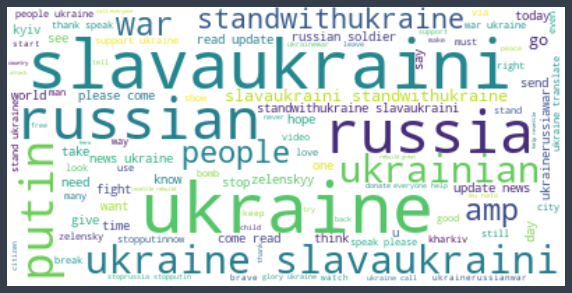

In [16]:
GraphicProcessors.generateWordcloud(sentiment_df[sentiment_df["sentiment"]==-1]["cleaned_tweet"].values)

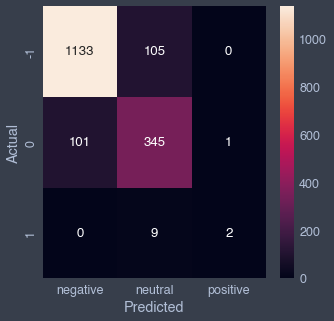

In [19]:
GraphicProcessors.graphConfusionmatrix(model_dict['LinearSVC']['conf_mat'], model_dict['sentiment_id'])

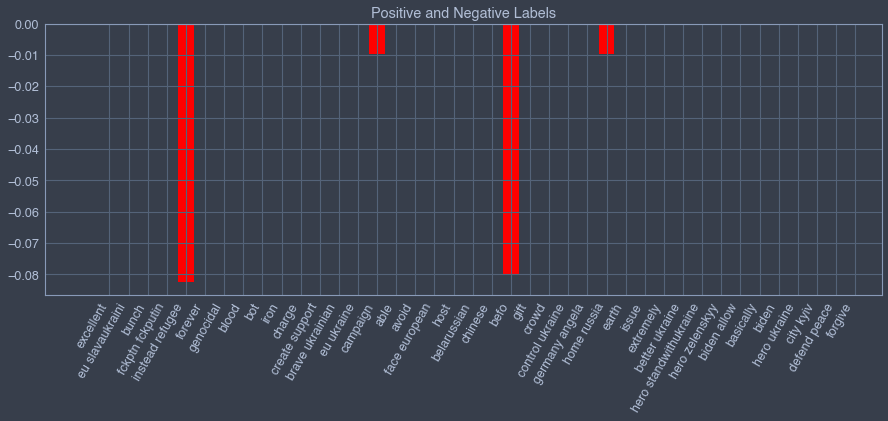

In [22]:
GraphicProcessors.graphCoefficients(model_dict['LinearSVC']['model'], model_dict['features'])